In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np 
from numpy import log
import gmaps 
import gmaps.datasets 
import matplotlib.pyplot as plt
import matplotlib.pyplot as set_ylim
from datetime import datetime
import shap
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')
from mpl_toolkits.axes_grid1 import make_axes_locatable

<h4>Load data</h4>

In [3]:
# import predictions data for use in the carbon zero simulation
y_hat_pred = pd.read_csv('stationary-data/y_hat_pred.csv')

In [4]:
# read in X_train data
X_train = pd.read_csv('stationary-data/X_train.csv')

In [5]:
# read in X_train data
y_train = pd.read_csv('stationary-data/y_train.csv')

In [6]:
# join predictions with X_train 
resid_df = X_train

#### Combine X_train, y_train and predictions into one df

In [7]:
resid_df['code_release_act'] = y_train['code_release']

In [8]:
resid_df['code_release_pred'] = y_hat_pred['0']

In [9]:
resid_df.head()

,Unnamed: 0,avg_kwh,Latitude,Longitude,Heated_SquareFeet,kwh_per_sqft,code_release_act,code_release_pred
0,6410,1027.639344,29.705515,-82.364586,1516.0,0.677862,16,18.222697
1,4903,766.774510,29.612746,-82.371744,1172.0,0.654244,24,22.314886
2,367,544.843137,29.611465,-82.360356,5944.0,0.091663,20,20.022693
3,2448,1026.689320,29.675848,-82.384052,1684.0,0.609673,20,18.148814
4,4206,500.291262,29.635181,-82.343227,1120.0,0.446689,18,18.933236


#### Create a feature for residual of the predicted code release year

In [10]:
# create a feature for 
resid_df['pred_resid'] = resid_df['code_release_act'] - resid_df['code_release_pred']

#### Plot distribution of predicted code release year residuals

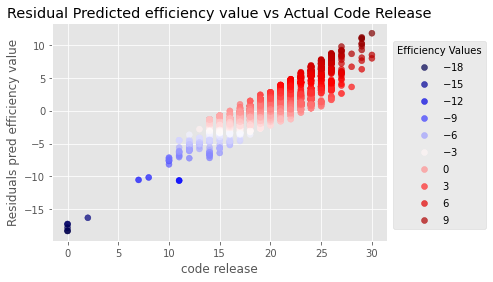

In [11]:
# plot efficiency value residual across code releases

x = resid_df['code_release_act']
y = resid_df['pred_resid']

# cmap['Diverging'] = [
#             'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
#             'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

c = resid_df['pred_resid']


fig, ax = plt.subplots()

scatter = ax.scatter(x, y, c=c, cmap='seismic', alpha=0.7)
# cbar = plt.colorbar()
# cbar.set_label('Efficiency Value')
ax.set_title('Residual Predicted efficiency value vs Actual Code Release')
ax.set_xlabel('code release')
ax.set_ylabel('Residuals pred efficiency value')

legend = ax.legend(*scatter.legend_elements(),
                    loc="lower right", bbox_to_anchor=(1.31, 0.03), title="Efficiency Values")
plt.show()

When the predicted release year is less than the actual code release year then the residual is a positive value. This indicates that the building is less efficient than expected given the efficiency standards the year it was built. There may be an opportunity for energy efficiency professionals to have a bigger impact on improvements to those buildings.

#### Plot distribution of actual and predicted code release years

In [41]:
# create df for count of actual code release & predicted values
code_perf_dist = resid_df[['code_release_pred', 'code_release_act']].groupby('code_release_act').agg('count')
code_perf_dist = code_perf_dist.reset_index()
                                                                             

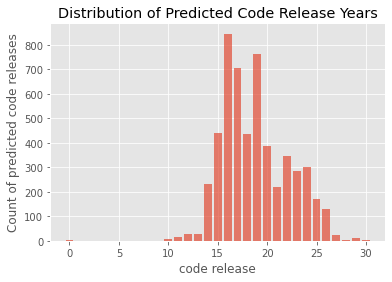

In [40]:
# plot distribution of predicted code release years

x = code_perf_dist['code_release_act']
y = code_perf_dist['code_release_pred']


fig, ax = plt.subplots()

ax.bar(x, y, alpha=0.7)
ax.set_title('Distribution of Predicted Code Release Years')
ax.set_xlabel('code release')
ax.set_ylabel('Count of predicted code releases')

plt.show()

In [46]:
# create df with the count of actual code release year 
code_act_dist = resid_df[['code_release_act']].groupby('code_release_act').agg('count')
resid_df.head()                                                                        

,Unnamed: 0,avg_kwh,Latitude,Longitude,Heated_SquareFeet,kwh_per_sqft,code_release_act,code_release_pred,pred_resid
0,6410,1027.639344,29.705515,-82.364586,1516.0,0.677862,16,18.222697,-2.222697
1,4903,766.774510,29.612746,-82.371744,1172.0,0.654244,24,22.314886,1.685114
2,367,544.843137,29.611465,-82.360356,5944.0,0.091663,20,20.022693,-0.022693
3,2448,1026.689320,29.675848,-82.384052,1684.0,0.609673,20,18.148814,1.851186
4,4206,500.291262,29.635181,-82.343227,1120.0,0.446689,18,18.933236,-0.933236


In [ ]:
# plot efficiency value residual across code releases

x = code_act_dist['code_release_act']
y = code_act_dist['code_release_pred']


fig, ax = plt.subplots()

ax.bar(x, y, alpha=0.7)
ax.set_title('Distribution of Predicted Code Release Years')
ax.set_xlabel('code release')
ax.set_ylabel('Count of predicted code releases')

plt.show()

#### Create feature for efficiency improvement rollout groups 

In [40]:
# sort df by prediction residuals (greater values being a higher priority for efficiency improvements)
preds_min_df = resid_df.sort_values(by=['pred_resid'], ascending=False)

In [94]:
preds_min_df.head()

,Unnamed: 0,avg_kwh,Latitude,Longitude,Heated_SquareFeet,kwh_per_sqft,code_release_act,code_release_pred,pred_resid,phase
0,1772,336.141414,29.655511,-82.303003,1032.0,0.325718,30,17.991768,12.008232,12.008232
1,2664,781.207317,29.657335,-82.301698,1288.0,0.606527,29,17.866151,11.133849,11.133849
2,7787,419.770000,29.654719,-82.303309,1647.0,0.254869,29,17.977489,11.022511,11.022511
3,10658,726.708738,29.665694,-82.391749,2382.0,0.305083,29,18.101922,10.898078,10.898078
4,9180,640.279070,29.636609,-82.335384,2064.0,0.310213,29,18.653999,10.346001,10.346001


In [90]:
# reset index
preds_min_df = preds_min_df.reset_index(drop=True)

In [89]:
# label residuals as phase column
preds_min_df['phase'] = preds_min_df['pred_resid']

In [98]:
# create df ordered by residuals
phase_df = preds_min_df[['phase']]

In [101]:
# label observations by phase after dividing sorted df evenly into 4 groups 
phase_num = len(preds_min_df)/4
phase_1 = phase_num
phase_2 = phase_num*2
phase_3 = phase_num*3
phase_4 = phase_num*4


phase_df.loc[0:phase_1, 'phase'] = 1
phase_df.loc[phase_1:phase_2, 'phase'] = 2
phase_df.loc[phase_2:phase_3, 'phase'] = 3
phase_df.loc[phase_3:phase_4, 'phase'] = 4


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [108]:
# add the phase column and values back into the observations df
preds_min_df['phase'] = phase_df

In [109]:
# calculate avg kwh for each phase 
phase_1_avg = preds_min_df[preds_min_df['phase'] == 1]['avg_kwh'].agg('mean')
phase_2_avg = preds_min_df[preds_min_df['phase'] == 2]['avg_kwh'].agg('mean')
phase_3_avg = preds_min_df[preds_min_df['phase'] == 3]['avg_kwh'].agg('mean')
phase_4_avg = preds_min_df[preds_min_df['phase'] == 4]['avg_kwh'].agg('mean')
print(phase_1_avg, phase_2_avg, phase_3_avg, phase_4_avg)

3380.4700567676987 2656.765915235126 2419.883118319462 3141.332532961318
